# 5AI03 - TP - ESTIMATION DE MOUVEMENT

## EXERCICE 1: D  ́ETECTION DE POINTS D’INTERET

L’objectif de cet exercice est d’impl  ́ementer et d’  ́etudier deux algorithmes de d  ́etection de points d’int  ́e

- Importation de dépendances

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import skimage as ski
from scipy.signal import convolve2d, convolve

from skimage import draw

import random


- Chargement et visualisation de l'image 

(300, 400)

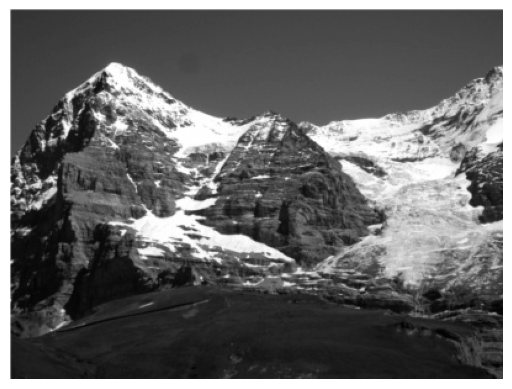

In [2]:
filename = "Docs - Primitives-20230926\pics\M1.JPG"
img = ski.io.imread(filename)
img_gray = ski.color.rgb2gray(img)

plt.imshow(img_gray, cmap='gray')
plt.axis('off')
img_gray.shape

## Q1/a - Implémentation de détecteur de Harris avec une fenêtre rectangulaire et gaussienne

-  On définit la fonction harris_detector(), qui prend en entrée l'image en noir et blanc dont les valeurs d'intensité des pixels varient entre 0 et 1, le seuil, le paramètre 'k', et le paramètre booléen 'gauss' qui détermine la nature de la fenêtre. Les sorties de la fonction sont "corners", qui correspond à une matrice de la même taille que l'image, où 1 signifie qu'il s'agit d'un coin et 0 qu'il ne s'agit pas d'un coin, et "C", qui correspond à la matrice C, le critère de Harris.

In [3]:
def harris_detector(img: np.ndarray, WS: int = 3, threshold: float = 0.01, k:float = 0.04, gauss: bool = False) :

    Ix, Iy= np.gradient(img) # calcule du gardient 


    Ixx = Ix**2
    Iyy = Iy**2
    Ixy = Ix*Iy

    if gauss == 1 :
        # Apply Gaussian blurring with
        Ixx = ski.filters.gaussian(Ixx, sigma=(WS-1)/6)
        Iyy = ski.filters.gaussian(Iyy, sigma=(WS-1)/6)
        Ixy = ski.filters.gaussian(Ixy, sigma=(WS-1)/6)


    m = np.ones([WS,WS])

    cIxx = convolve2d(Ixx,m,'same')
    cIyy = convolve2d(Iyy,m,'same')
    cIxy = convolve2d(Ixy,m,'same')

    C = (cIxx * cIyy - cIxy * cIxy) - k * (cIxx + cIyy)

    corners = np.zeros_like(img)
    corners[C > threshold * C.max()] = [1]  # Marque le point

    C[0,0] = 0
    corners[0,0] = 0
    
    return corners, C  


- Tester la fonction harris_detector()

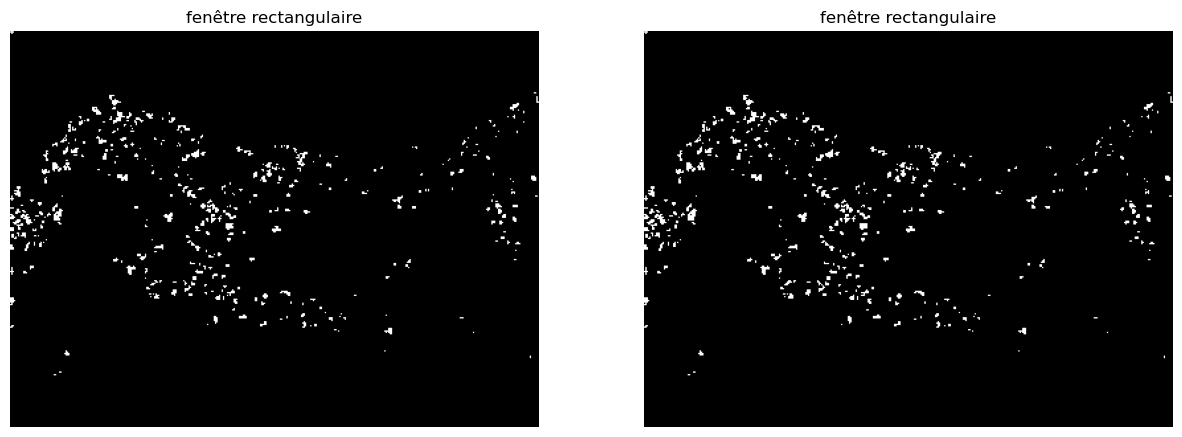

In [4]:
# Détection des coins à l'aide du détecteur de Harris avec une fenêtre rectangulaire
corner_image_1, C_1 = harris_detector(img_gray, k=0.04,gauss = False)

# Détection des coins à l'aide du détecteur de Harris avec fenêtre gaussienne
corner_image_2, C_2 = harris_detector(img_gray, k=0.04,gauss = True)

plt.figure(figsize=(15, 10))

# fenêtre rectangulaire
plt.subplot(1,2,1)
plt.imshow(corner_image_1, cmap='gray')
plt.title("fenêtre rectangulaire")
plt.axis('off')

# Fenêtre gaussienne
plt.subplot(1,2,2)
plt.imshow(corner_image_2, cmap='gray')
plt.title("fenêtre rectangulaire")
plt.axis('off')


plt.show()

## Q1/b - Implémentation d'un suppresseur des non-maxima locaux

- On définit une fonction RLM() qui prend en entrée le critère "C" et la taille de la fenêtre "WS". La sortie est "corner_out", une matrice de la même taille que l'image, qui localise les coins qui ont été sélectionnés apprêt la suppression des non-maxima locaux. Le filtre analyse tous les éléments de la matrice "C" et vérifie si la valeur de l'élément est supérieure à un seuil et s'il s'agit de la plus grande valeur dans la fenêtre déterminée, si c'est le cas, il sera marqué comme un coin, si ce n'est pas le cas, il ne le sera pas.

In [5]:
def RLM(C, WS=5,threshold=0.01):
    height, width = C.shape

    offset = WS //2

    corner_out = np.zeros([height, width])

    for i in range(offset, height-offset) :
        for j in range(offset, width-offset) : 

            if C[i,j] < C[i-offset:i+offset+1,j-offset:j+offset+1].max() or C[i,j] < C.max()*threshold :
                corner_out[i,j] = 0
            else:
                corner_out[i,j] = 1


    return corner_out

- test de la fonction

(-0.5, 399.5, 299.5, -0.5)

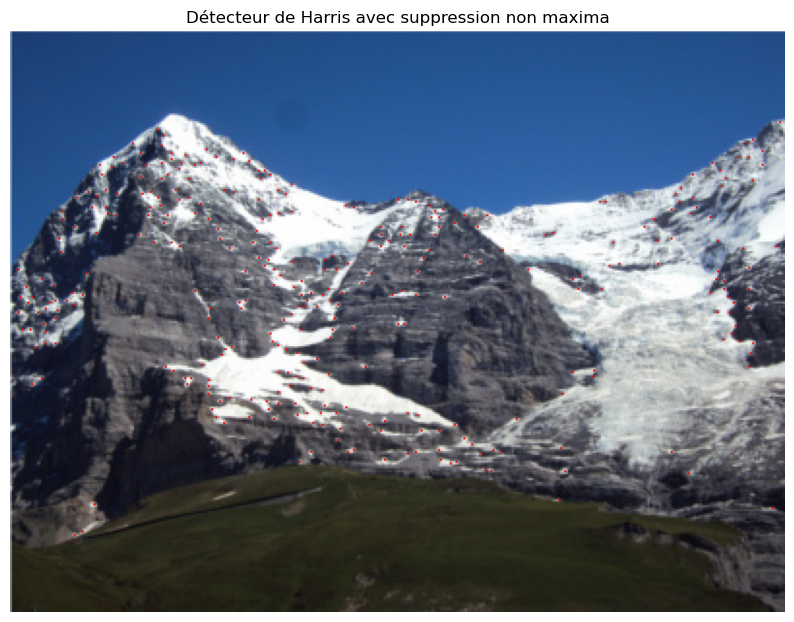

In [6]:
# La fonction RLM est appliquée à l'image traitée précédemment
corner_rlm = RLM(C_1)


plt.figure(figsize=(10, 10))

img_Harris_RLM = img.copy()
img_Harris_RLM[corner_rlm > 0.01 * corner_rlm.max()] = [255,0,0] # on marque les coins en rouge

plt.imshow(img_Harris_RLM)
plt.title("Détecteur de Harris avec suppression non maxima")
plt.axis('off')


## Q1/c - Étude de l'influence de la taille de la fenêtre et du paramètre K

In [7]:

WSs = [1,3,5,7,9]
K = [0.01,0.04,0.05,0.06,0.1]


plt.figure(figsize=(15, 13))
i = 1
for k in K :
    for ws in WSs :

        plt.subplot(5,5,i)
        i += 1

        _, C = harris_detector(img_gray, k=k,WS = ws, gauss = False)
        # corner_rlm = RLM(C, WS = ws)
        corner_rlm = C

        img_Harris_RLM = img.copy()
        img_Harris_RLM[corner_rlm > 0.01 * corner_rlm.max()] = [255,0,0] # on marque les coins en rouge

        plt.imshow(img_Harris_RLM)
        plt.title(f'k = {k}, WS = {ws}')
        plt.axis('off')
        



## Commentaire : 
- En ce qui concerne la taille de la fenêtre du détecteur de Harris, on peut observer que plus la fenêtre est grande, plus le filtre considérera davantage de points comme des coins. Cela s'explique par le fait que plus la fenêtre est grande, plus il y a de chances qu'elle englobe un changement d'intensité significatif. Dans de telles situations, le détecteur classera le point comme un coin.

- Pour la valeur de k, elle a un impact négatif sur la sensibilité du filtre, donc, pour un point donné dans l'image, il a plus de chances d'être détecté comme un coin lorsque k est petit par rapport à une valeur élevée de k. Les valeurs utilisées pour k se situent entre 0.04 et 0.06, mais on a expérimenter des valeurs telles que 0.01 et 0.1 pour amplifier son effet.

## Q1/d - Tester le détecteur sur une image après rotation 

In [8]:
rot_img = ski.transform.rotate(img, 45)
rot_img_gray = ski.color.rgb2gray(rot_img)

WSs = [1,3,5,7]
G = [False, True]


plt.figure(figsize=(15, 13))
i = 1

for gauss in G :
    for ws in WSs :

        _, C1 = harris_detector(img_gray, k=0.04,WS = ws, gauss = gauss)
        _, C2 = harris_detector(rot_img_gray, k=0.04,WS = ws, gauss = gauss)

        # corner_rlm_1 = RLM(C1, WS = ws)
        # corner_rlm_2 = RLM(C2, WS = ws)

        corner_rlm_1 = C1
        corner_rlm_2 = C2

        plt.subplot(4,4,i)
        
        img_Harris_RLM = img.copy()
        img_Harris_RLM[corner_rlm_1 > 0.01 * corner_rlm_1.max()] = [255,0,0] # on marque les coins en rouge

        plt.imshow(img_Harris_RLM)
        plt.title(f'gauss = {gauss}, WS = {ws}')
        plt.axis('off')

        plt.subplot(4,4,i+1)

        img_Harris_RLM_r = rot_img.copy()
        img_Harris_RLM_r[corner_rlm_2 > 0.01 * corner_rlm_2.max()] = [255,0,0] # on marque les coins en rouge

        plt.imshow(img_Harris_RLM_r)
        plt.title(f'gauss = {gauss}, WS = {ws}')
        plt.axis('off')

        i += 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


## Commentaire : 
- Il est possible d'observer que le détecteur a identifié des régions similaires dans l'image avant et après la rotation, bien que pas de manière parfaitement identique. La taille de la fenêtre et l'utilisation d'une fenêtre gaussienne ont contribué quelque peu à cette similarité.

## Q2/a - L'implémentation détecteur FAST

- On définit la fonction fast() qui prend en entre l'image en noir et blanc et la seille, et sortie le critère 'C'.

In [9]:
def fast(img: np.ndarray, threshold=0.1):
    
    height, width = img.shape
    offset = 3
    
    C = np.zeros([height, width])
    
    for x in range(offset, height - offset) : 
        for y in range(offset, width - offset) :
            pixel_intensity = img[x, y]
            
            # Coordinates of the 16 pixels in the Bresenham circle
            offsets = [         (-1, 3),(0, 3),(1, 3),
                        (-2, 2),                      (2, 2), 
                (-3, 1),                                    (3, 1), 
                (-3, 0),                                    (3, 0), 
                (-3,-1),                                    (3,-1), 
                        (-2,-2),                      (2,-2), 
                                (-1,-3),(0,-3),(1,-3)]
            
            
            V = np.zeros([16])
            
            k = 0
            Is = 0
            for i, j in offsets:

                if (pixel_intensity - threshold > img[x+i, y+j]):
                    V[k] = 1
                
                if (pixel_intensity + threshold < img[x+i, y+j]):
                    V[k] = -1

                Is = abs(pixel_intensity + img[x+i, y+j])
                k+=1


            kernel = np.ones(12)
            padding = len(kernel) // 2

            padded_signal = np.concatenate([V[-padding:], V, V[:padding]])
            result = np.convolve(padded_signal, kernel, mode='valid')
            

            r = abs(result[padding:-padding]).max()

            if r >= 12 :
                C[x, y] = Is/16

    return C

(-0.5, 399.5, 299.5, -0.5)

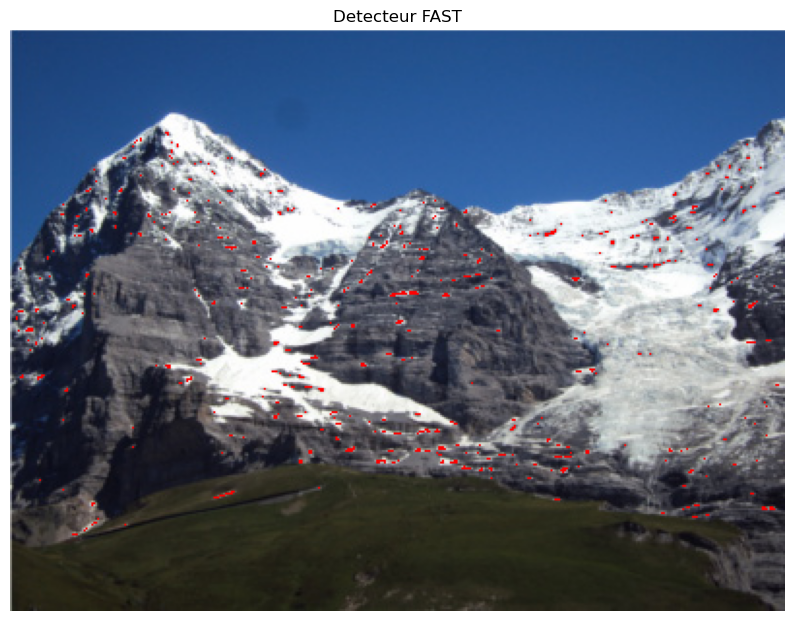

In [10]:
corner_fast = fast(img_gray, threshold=0.15)


plt.figure(figsize=(10, 10))

img_Fast = img.copy()
img_Fast[corner_fast  > 0 ] = [255,0,0]
plt.imshow(img_Fast)
plt.title("Detecteur FAST")
plt.axis('off')



## Q2/b - Implémentation d'un suppresseur des non-maxima locaux

- On a utilisé la même fonction RLM() que celle déjà définie dans Q1/b, pour le score, la fonction fast() est implémentée de telle manière que la sortie 'C' est la somme des écarts entre le pixel en question et son voisinage, donc on va l'utiliser pour la surpression des mon-maxima locaux.

(-0.5, 399.5, 299.5, -0.5)

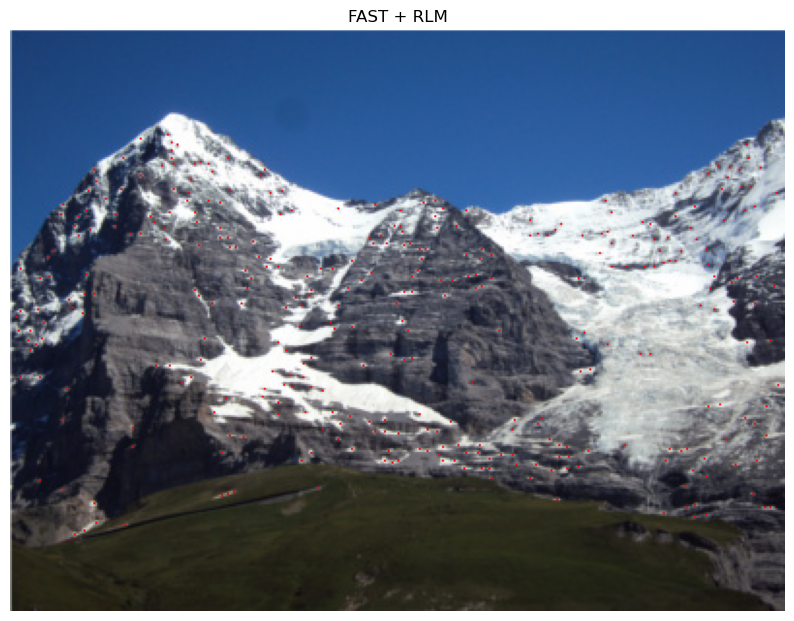

In [11]:
corner_fast_rlm = RLM(corner_fast)

plt.figure(figsize=(10, 10))

img_Fast = img.copy()
img_Fast[corner_fast_rlm > 0 ] = [255,0,0]
plt.imshow(img_Fast)
plt.title("FAST + RLM")
plt.axis('off')


## Q2/c - Tester le détecteur sur une image après rotation 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


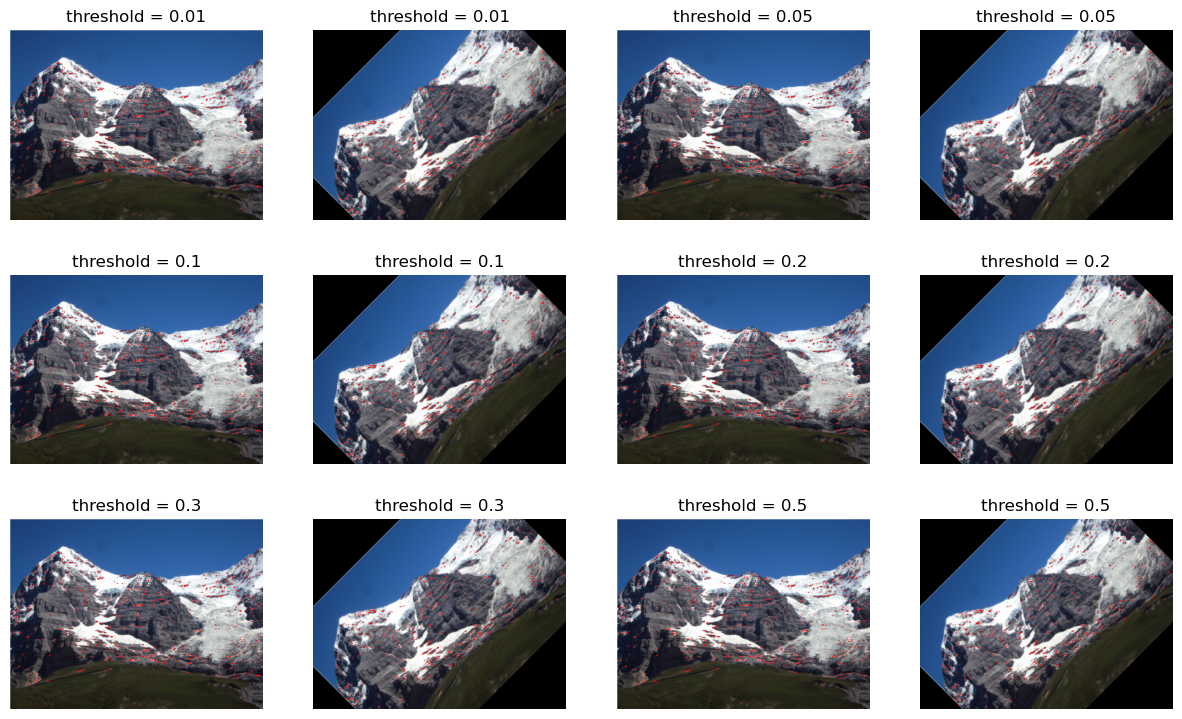

In [12]:
plt.figure(figsize=(15, 9))

thresholds = [0.01,0.05,0.1,0.2,0.3,0.5]
i = 1
for threshold in thresholds :
    C1 = fast(img_gray, threshold=0.1)
    C2 = fast(rot_img_gray, threshold=0.1)

    plt.subplot(3,4,i)

    img_Harris_RLM = img.copy()
    img_Harris_RLM[C1 > 0] = [255,0,0] # on marque les coins en rouge

    plt.imshow(img_Harris_RLM)
    plt.title(f'threshold = {threshold}')
    plt.axis('off')

    plt.subplot(3,4,i+1)

    img_Harris_RLM_r = rot_img.copy()
    img_Harris_RLM_r[C2 > 0] = [255,0,0] # on marque les coins en rouge

    plt.imshow(img_Harris_RLM_r)
    plt.title(f'threshold = {threshold}')
    plt.axis('off')

    i+= 2



## Q3 - Comparaison entre Harris, FAST, CV2-Harris, CV2-FAST

- Dans cette section, nous allons comparer notre détecteur de Harris avec celui de la bibliothèque OpenCV (CV2), de même que pour l'algorithme FAST.

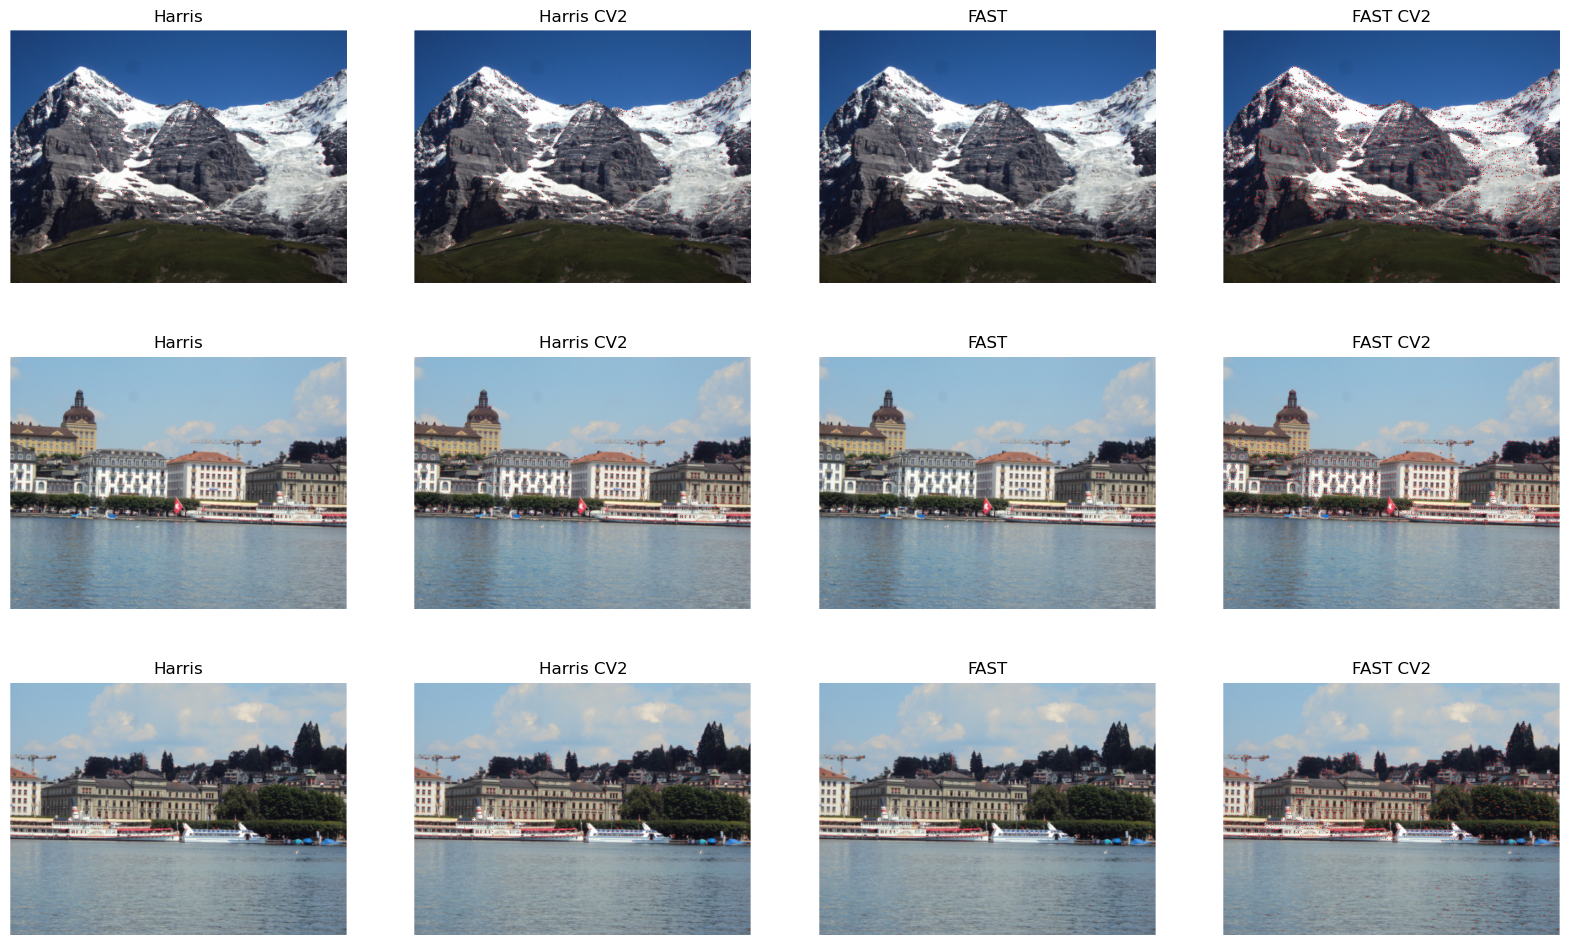

In [22]:
files = ['M1', 'P2', 'P3']

plt.figure(figsize=(20, 12))

i = 1
for file in files :

    img = cv2.imread('Docs - Primitives-20230926/pics/' + file + '.JPG', cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.imread('Docs - Primitives-20230926/pics/' + file + '.JPG', cv2.IMREAD_GRAYSCALE)
    
    _,C1 = harris_detector(img_gray/ 255.0, threshold=0.1)
    C1 = RLM(C1)

    C2 = cv2.cornerHarris(img_gray, blockSize=3, ksize=3, k=0.04)
    C2 = RLM(C2)

    C3 = fast(img_gray/ 255.0, threshold=0.15)
    C3 = RLM(C3)

    fast_func = cv2.FastFeatureDetector_create(threshold=20, nonmaxSuppression=True)
    C4 = fast_func.detect(img_gray, None)
    
    

    plt.subplot(3,4,i)

    img_Harris = img_rgb.copy()
    img_Harris[C1 > 0] = [255,0,0] # on marque les coins en rouge

    plt.imshow(img_Harris)
    plt.title('Harris')
    plt.axis('off')

    plt.subplot(3,4,i+1)

    img_Harris_CV2 = img_rgb.copy()
    img_Harris_CV2[C2 > 0] = [255,0,0] # on marque les coins en rouge

    plt.imshow(img_Harris_CV2)
    plt.title('Harris CV2')
    plt.axis('off')



    plt.subplot(3,4,i+2)

    img_FAST = img_rgb.copy()
    img_FAST[C3 > 0] = [255,0,0] # on marque les coins en rouge

    plt.imshow(img_FAST)
    plt.title('FAST')
    plt.axis('off')

    plt.subplot(3,4,i+3)

    img_FAST_cv2 = img_rgb.copy()
    for keypoint in C4:
        y, x = keypoint.pt
        img_FAST_cv2[int(x),int(y)] = [255,0,0] # on marque les coins en rouge


    plt.imshow(img_FAST_cv2)
    plt.title('FAST CV2')
    plt.axis('off')

    i+= 4



# EX2

In [14]:
def vect_int(img_gray, corner_response, blocSize=5):
    corner_response_rlm = RLM(corner_response)

    indices = np.argwhere(corner_response_rlm==1)

    # print(indices)
    V = np.zeros([len(indices),blocSize**2])

    h,w = img_gray.shape
    

    #print(w,h)

    indices_out = indices.copy()

    off = blocSize // 2
    i = 0
    for x,y in indices :

        # print(x,y)

        if x < off or y < off or x > h - off or x > w - off :

            print(x,y)
            indices_out = np.delete(indices_out, i, axis=0)
            i += 1

        else:

            I = img_gray[x-off:x+off+1,y-off:y+off+1]

            V[i,:] = I.flatten()
            i += 1
            
        
    return V,indices_out


In [15]:
filename1 = "Docs - Primitives-20230926\pics\M1.JPG"
filename2 = "Docs - Primitives-20230926\pics\M2.JPG"

img1_gray = ski.color.rgb2gray(ski.io.imread(filename1))
img2_gray = ski.color.rgb2gray(ski.io.imread(filename2))

# corner_response_1 = fast_corner_detector(img1_gray, threshold=0.15)
# corner_response_2 = fast_corner_detector(img2_gray, threshold=0.15)

_, corner_response_1 = harris_detector(img1_gray, k=0.04,gauss = True)
_, corner_response_2 = harris_detector(img2_gray, k=0.04,gauss = True)

corner_response_rlm_1 = RLM(corner_response_1)
corner_response_rlm_2 = RLM(corner_response_2)

V1,cor1 = vect_int(img1_gray, corner_response_rlm_1)
V2,cor2 = vect_int(img2_gray, corner_response_rlm_2)

print(V1.shape, V2.shape)

(335, 25) (376, 25)


In [16]:
def match(V1,V2) :
    # x,y = len(V1), len(V2)

    # D = np.zeros([x,y])

    # for i in range(x):
    #     v1 = V1[i,:]

    #     for j in range(y):
    #         v2 = V2[j,:]

    #         D[i,j] = np.abs(v1 - v2).sum()

    V1 = V1[:, np.newaxis,:]

    V = abs(V1 - V2)

    V = V.sum(axis=2)

    return V

In [17]:

def get_maxs(V1, V2, n):

    D = match(V1,V2)
    X = []
    Y = []
    for _ in range(n) :

        x,y = np.unravel_index(np.argmin(D, axis=None), D.shape)

        X.append(x)
        Y.append(y)

        D[x,:] = D.max()
        D[:,y] = D.max()

    return X, Y


In [18]:
pv1,pv2 = get_maxs(V1, V2, 10)

P1 = cor1[pv1]
P2 = cor2[pv2]



In [19]:
dist = np.sqrt((P1 - P2)**2).sum(axis=1)
avg = np.average(dist)

np.any(abs(dist - avg) > 5)

True

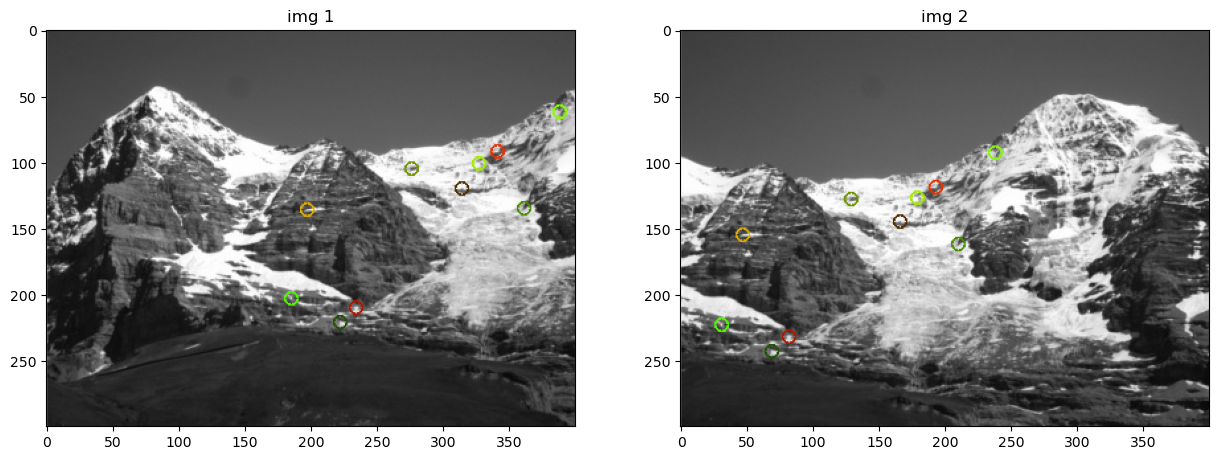

In [20]:
img1 = ski.color.gray2rgb(img1_gray)
img2 = ski.color.gray2rgb(img2_gray)


for i in range(len(P1)) :

    r = random.random()
    g = random.random()
    b = 0
    
    rr1, cc1, _ = draw.circle_perimeter_aa(P1[i,0],P1[i,1], radius=5, shape=img1.shape)
    img1[rr1, cc1] = (r,g,0)

    rr2, cc2, _ = draw.circle_perimeter_aa(P2[i,0],P2[i,1], radius=5, shape=img2.shape)
    img2[rr2, cc2] = [r,g,0]

# Display the corners on the original image
plt.figure(figsize=(15, 10))

plt.subplot(1,2,1)
plt.imshow(img1)
plt.title("img 1")

# CV2
plt.subplot(1,2,2)
plt.imshow(img2)
plt.title("img 2")

plt.show()

In [21]:
a = np.array([[1,2,3],
              [2,2,2],
              [1,1,1],
              [1,5,1]])

b = np.array([[1,2,3],
              [4,5,2],
              [1,8,1]])

a = a[:, np.newaxis,:]

c = abs(b - a)

c = c.sum(axis=2)

c[1,0]

2